In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,f1_score,classification_report,confusion_matrix

In [2]:
data=pd.read_csv(r"C:\Users\Anna\PycharmProjects\NLP\spam.csv",encoding='ISO-8859-1')

In [3]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
data.shape

(5572, 5)

In [5]:
data['Unnamed: 2'].notna().sum()

50

In [6]:
data['Unnamed: 3'].notna().sum()

12

In [7]:
data['Unnamed: 4'].notna().sum()

6

In [8]:
data=data.iloc[:,:2]

In [9]:
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
data.columns = ['label', 'message']

In [11]:
data.isna().sum()

label      0
message    0
dtype: int64

In [12]:
data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

# Training a SVM and Random Forest models on TF-IDF vectorization of balanced dataset, accuracy is 0.962.

In [13]:
spam=data[data['label']=='spam']

In [14]:
ham=data[data['label']=='ham']

In [15]:
ham=ham.sample(spam.shape[0])

In [16]:
ham.shape,spam.shape

((747, 2), (747, 2))

In [17]:
balanced_dataset=spam.append(ham,ignore_index=True)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(balanced_dataset['message'], balanced_dataset['label'], test_size=0.33, random_state=42)

In [19]:
classifier = Pipeline([('tfidf', TfidfVectorizer()), ('classifier', SVC())])
classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
print("Accuracy score  with SVM model is ",accuracy_score(y_test, y_pred).round(3),"for balanced dataset")

Accuracy score  with SVM model is  0.966 for balanced dataset


In [20]:
classifier_forest = Pipeline([('tfidf', TfidfVectorizer()), ('classifier', RandomForestClassifier(random_state=0))])
classifier_forest.fit(X_train, y_train)
y_pred=classifier_forest.predict(X_test)
print("Accuracy score  with Random Forest model is ",accuracy_score(y_test, y_pred).round(3),"for balanced dataset")

Accuracy score  with Random Forest model is  0.957 for balanced dataset


# Training a SVM and Random Forest models on TF-IDF vectorization of imbalanced dataset, f1 score is 0.99.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data['message'], data['label'], test_size=0.33, random_state=42)

In [22]:
classifier_forest = Pipeline([('tfidf', TfidfVectorizer()), ('classifier', RandomForestClassifier(random_state=0))])
classifier_forest.fit(X_train, y_train)
y_pred=classifier_forest.predict(X_test)
print("f1 score with Random Forest model is ",f1_score(y_test, y_pred,pos_label='ham').round(3),"for imbalanced dataset")

f1 score with Random Forest model is  0.987 for imbalanced dataset


In [23]:
classifier = Pipeline([('tfidf', TfidfVectorizer()), ('classifier', SVC(C=10, gamma=0.1))])
classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
print("f1 score  with SVM model is ",f1_score(y_test, y_pred,pos_label='ham').round(3),"for imbalanced dataset")
print("It's a best result.")
print('\n',confusion_matrix(y_test, y_pred))
print('\n',classification_report(y_test, y_pred))

f1 score  with SVM model is  0.991 for imbalanced dataset
It's a best result.

 [[1582    5]
 [  25  227]]

               precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1587
        spam       0.98      0.90      0.94       252

    accuracy                           0.98      1839
   macro avg       0.98      0.95      0.96      1839
weighted avg       0.98      0.98      0.98      1839



# Find best parameters for SVM model

In [24]:
tf_vectorizer=TfidfVectorizer(min_df=4,max_df=0.3,ngram_range=(1,3))
X_train_tfidf=tf_vectorizer.fit_transform(X_train)
X_test_tfidf=tf_vectorizer.transform(X_test)

In [25]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
classifier = SVC()  
grid = GridSearchCV(classifier, param_grid, refit = True, verbose = 3)
grid.fit(X_train_tfidf, y_train)
print(grid.best_params_)
print(grid.best_estimator_)
grid_predictions = grid.predict(X_test_tfidf)
print(classification_report(y_test, grid_predictions))

# spam detecion with CNN

In [26]:
data['label']=data['label'].map({'ham':0,'spam':1})

In [28]:
X_train, X_test, y_train, y_test = train_test_split(data['message'], data['label'], test_size=0.33, random_state=42)

In [29]:
max_vocab_size=20000

In [30]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
import tensorflow as tf

In [31]:
tokenizer=Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(X_train)
sequences_train=tokenizer.texts_to_sequences(X_train)
sequences_test=tokenizer.texts_to_sequences(X_test)

In [32]:
len(sequences_train)

3733

In [33]:
word2indx=tokenizer.word_index

In [34]:
VOCABULARY_SIZE=len(word2indx)
EMBEDDINGS_DIM=20

In [35]:
data_train=pad_sequences(sequences_train)
T=data_train.shape[1]
data_test=pad_sequences(sequences_test,maxlen=T)

In [36]:
data_test.shape

(1839, 121)

In [38]:
VOCABULARY_SIZE

7259

In [40]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D,LSTM

In [44]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=VOCABULARY_SIZE + 1, output_dim=EMBEDDINGS_DIM, input_length=len(data_train[1])))
model_lstm.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model_lstm.add(MaxPool1D())
model_lstm.add(LSTM(10))
model_lstm.add(Dense(8, activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
r_lstm=model_lstm.fit(data_train, y_train, validation_data=(data_test, y_test), epochs=50)

Epoch 1/50
117/117 [==============================] - 12s 61ms/step - loss: 0.3968 - accuracy: 0.8851 - val_loss: 0.1606 - val_accuracy: 0.9657
Epoch 2/50
117/117 [==============================] - 6s 49ms/step - loss: 0.0699 - accuracy: 0.9879 - val_loss: 0.0675 - val_accuracy: 0.9804
Epoch 3/50
117/117 [==============================] - 6s 49ms/step - loss: 0.0223 - accuracy: 0.9952 - val_loss: 0.0641 - val_accuracy: 0.9842
Epoch 4/50
117/117 [==============================] - 6s 50ms/step - loss: 0.0112 - accuracy: 0.9981 - val_loss: 0.0705 - val_accuracy: 0.9837
Epoch 5/50
117/117 [==============================] - 6s 49ms/step - loss: 0.0058 - accuracy: 0.9995 - val_loss: 0.0685 - val_accuracy: 0.9853
Epoch 6/50
117/117 [==============================] - 6s 50ms/step - loss: 0.0040 - accuracy: 0.9997 - val_loss: 0.0683 - val_accuracy: 0.9859
Epoch 7/50
117/117 [==============================] - 6s 49ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0708 - val_accuracy: 0.985

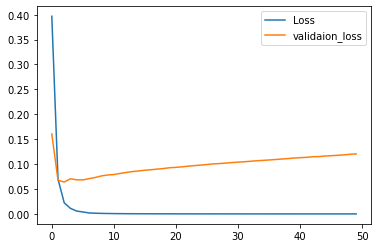

In [48]:
plt.plot(r_lstm.history['loss'],label="Loss")
plt.plot(r_lstm.history['val_loss'],label='validaion_loss')
plt.legend()

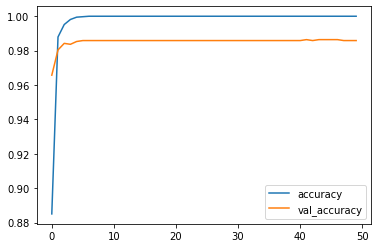

In [49]:
plt.plot(r_lstm.history['accuracy'],label="accuracy")
plt.plot(r_lstm.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [60]:
print("Accuracy score with LSTM CNN is ",r_lstm.history['val_accuracy'][-1])

Accuracy score with LSTM CNN is  0.9858618974685669
